# Generalized Linear Models

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

## GLM: Binomial response data

### Load Star98 data

 In this example, we use the Star98 dataset which was taken with permission
 from Jeff Gill (2000) Generalized linear models: A unified approach. Codebook
 information can be obtained by typing: 

In [3]:
print(sm.datasets.star98.NOTE)

::

    Number of Observations - 303 (counties in California).

    Number of Variables - 13 and 8 interaction terms.

    Definition of variables names::

        NABOVE   - Total number of students above the national median for the
                   math section.
        NBELOW   - Total number of students below the national median for the
                   math section.
        LOWINC   - Percentage of low income students
        PERASIAN - Percentage of Asian student
        PERBLACK - Percentage of black students
        PERHISP  - Percentage of Hispanic students
        PERMINTE - Percentage of minority teachers
        AVYRSEXP - Sum of teachers' years in educational service divided by the
                number of teachers.
        AVSALK   - Total salary budget including benefits divided by the number
                   of full-time teachers (in thousands)
        PERSPENK - Per-pupil spending (in thousands)
        PTRATIO  - Pupil-teacher ratio.
        PCTAF    - Percenta

Load the data and add a constant to the exogenous (independent) variables:

In [4]:
data = sm.datasets.star98.load()
data.exog = sm.add_constant(data.exog, prepend=False)

 The dependent variable is N by 2 (Success: NABOVE, Failure: NBELOW): 

In [5]:
print(data.endog.head())

   NABOVE  NBELOW
0   452.0   355.0
1   144.0    40.0
2   337.0   234.0
3   395.0   178.0
4     8.0    57.0


 The independent variables include all the other variables described above, as
 well as the interaction terms:

In [6]:
print(data.exog.head())

     LOWINC   PERASIAN   PERBLACK    PERHISP  PERMINTE  AVYRSEXP    AVSALK  \
0  34.39730  23.299300  14.235280  11.411120  15.91837  14.70646  59.15732   
1  17.36507  29.328380   8.234897   9.314884  13.63636  16.08324  59.50397   
2  32.64324   9.226386  42.406310  13.543720  28.83436  14.59559  60.56992   
3  11.90953  13.883090   3.796973  11.443110  11.11111  14.38939  58.33411   
4  36.88889  12.187500  76.875000   7.604167  43.58974  13.90568  63.15364   

   PERSPENK   PTRATIO     PCTAF  ...   PCTYRRND  PERMINTE_AVYRSEXP  \
0  4.445207  21.71025  57.03276  ...  22.222220         234.102872   
1  5.267598  20.44278  64.62264  ...   0.000000         219.316851   
2  5.482922  18.95419  53.94191  ...   0.000000         420.854496   
3  4.165093  21.63539  49.06103  ...   7.142857         159.882095   
4  4.324902  18.77984  52.38095  ...   0.000000         606.144976   

   PERMINTE_AVSAL  AVYRSEXP_AVSAL  PERSPEN_PTRATIO  PERSPEN_PCTAF  \
0       941.68811        869.9948        

### Fit and summary

In [7]:
glm_binom = sm.GLM(data.endog, data.exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     ['NABOVE', 'NBELOW']   No. Observations:                  303
Model:                              GLM   Df Residuals:                      282
Model Family:                  Binomial   Df Model:                           20
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -2998.6
Date:                  Mon, 16 Dec 2024   Deviance:                       4078.8
Time:                          09:56:09   Pearson chi2:                 4.05e+03
No. Iterations:                       5   Pseudo R-squ. (CS):              1.000
Covariance Type:              nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
LOWINC

### Quantities of interest

In [8]:
print('Total number of trials:',  data.endog.iloc[:, 0].sum())
print('Parameters: ', res.params)
print('T-values: ', res.tvalues)

Total number of trials: 108418.0
Parameters:  LOWINC                    -0.016815
PERASIAN                   0.009925
PERBLACK                  -0.018724
PERHISP                   -0.014239
PERMINTE                   0.254487
AVYRSEXP                   0.240694
AVSALK                     0.080409
PERSPENK                  -1.952161
PTRATIO                   -0.334086
PCTAF                     -0.169022
PCTCHRT                    0.004917
PCTYRRND                  -0.003580
PERMINTE_AVYRSEXP         -0.014077
PERMINTE_AVSAL            -0.004005
AVYRSEXP_AVSAL            -0.003906
PERSPEN_PTRATIO            0.091714
PERSPEN_PCTAF              0.048990
PTRATIO_PCTAF              0.008041
PERMINTE_AVYRSEXP_AVSAL    0.000222
PERSPEN_PTRATIO_PCTAF     -0.002249
const                      2.958878
dtype: float64
T-values:  LOWINC                    -38.749083
PERASIAN                   16.504736
PERBLACK                  -25.182189
PERHISP                   -32.817913
PERMINTE                

First differences: We hold all explanatory variables constant at their means and manipulate the percentage of low income households to assess its impact on the response variables: 

In [9]:
means = data.exog.mean(axis=0)
means25 = means.copy()
means25.iloc[0] = stats.scoreatpercentile(data.exog.iloc[:,0], 25)
means75 = means.copy()
means75.iloc[0] = lowinc_75per = stats.scoreatpercentile(data.exog.iloc[:,0], 75)
resp_25 = res.predict(means25)
resp_75 = res.predict(means75)
diff = resp_75 - resp_25


The interquartile first difference for the percentage of low income households in a school district is:

In [10]:
print("%2.4f%%" % (diff.iloc[0]*100))

-11.8753%


### Plots

 We extract information that will be used to draw some interesting plots: 

In [11]:
nobs = res.nobs
y = data.endog.iloc[:,0]/data.endog.sum(1)
yhat = res.mu

Plot yhat vs y:

In [12]:
from statsmodels.graphics.api import abline_plot

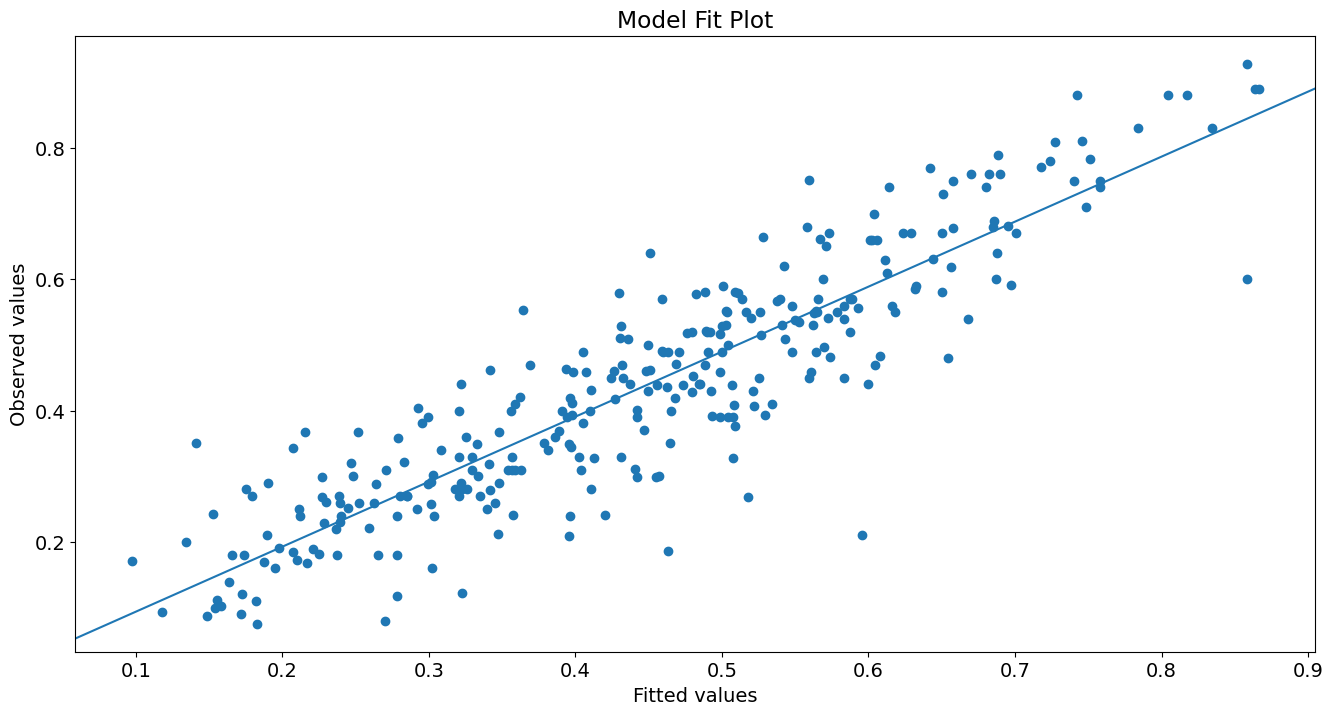

In [13]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

Plot yhat vs. Pearson residuals:

Text(0.5, 0, 'Fitted values')

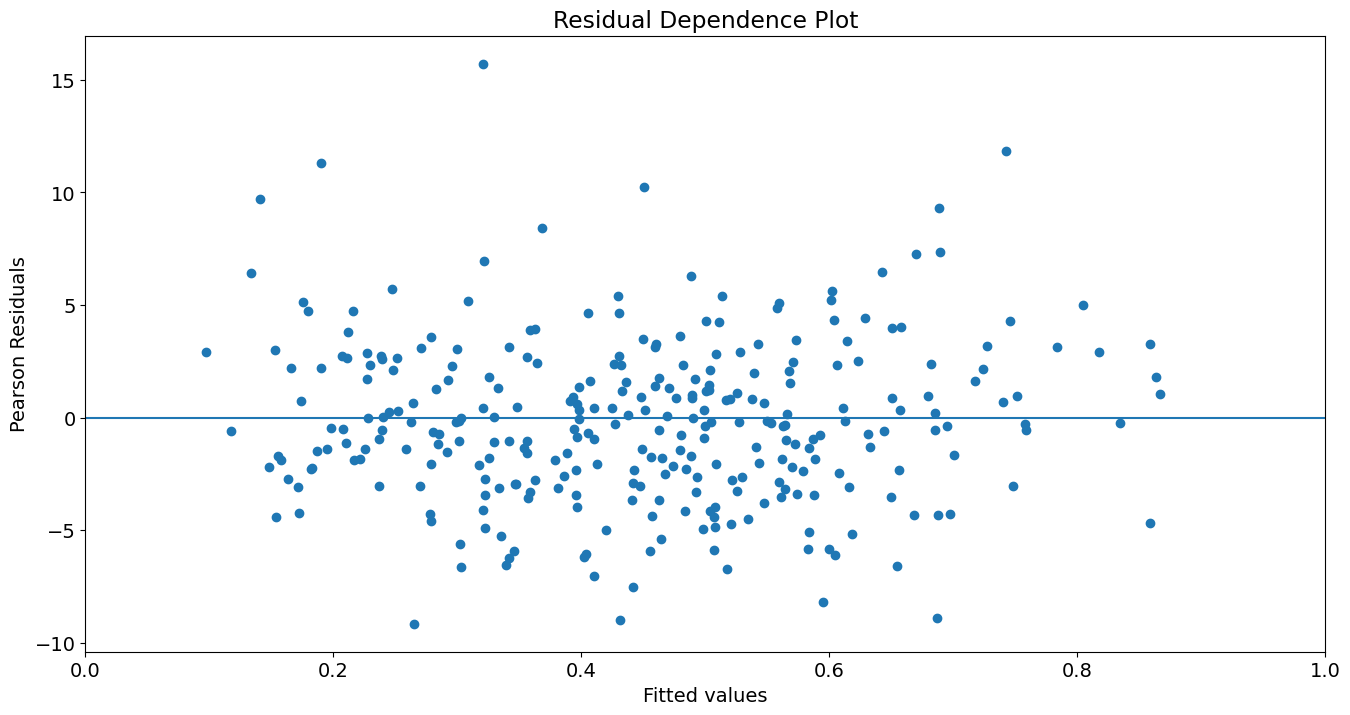

In [14]:
fig, ax = plt.subplots()

ax.scatter(yhat, res.resid_pearson)
ax.hlines(0, 0, 1)
ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

Histogram of standardized deviance residuals:

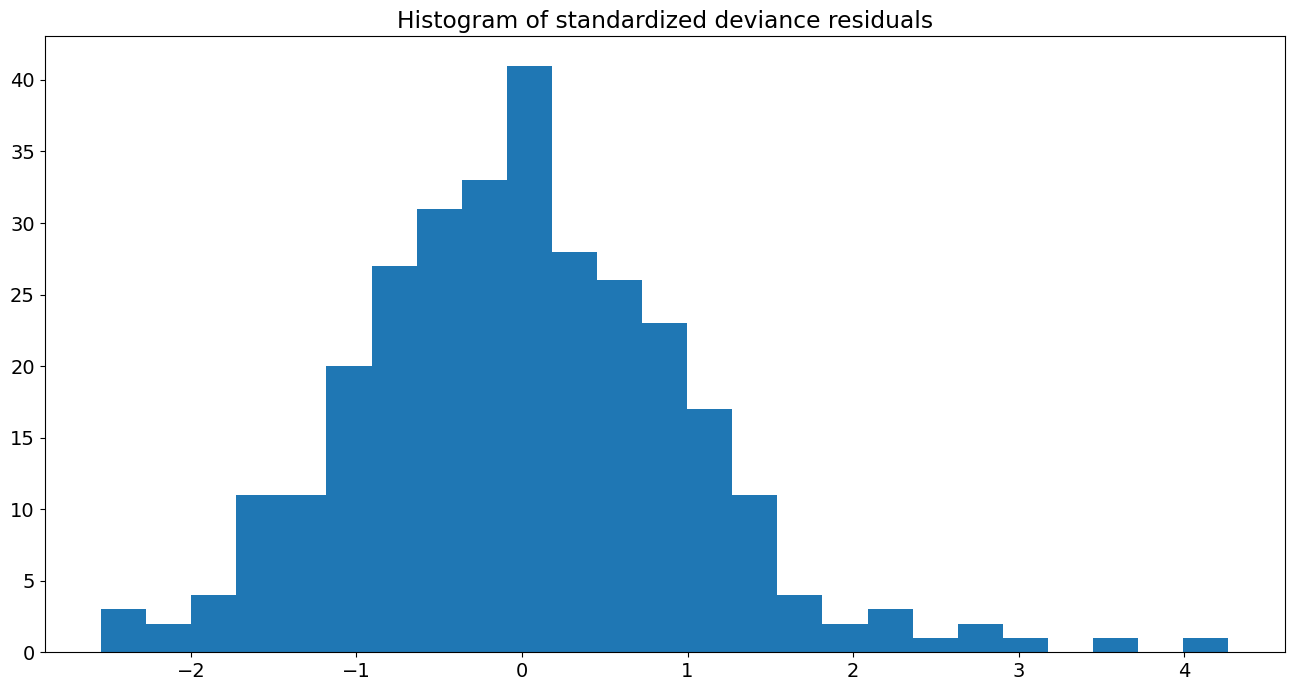

In [15]:
from scipy import stats

fig, ax = plt.subplots()

resid = res.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

QQ Plot of Deviance Residuals:

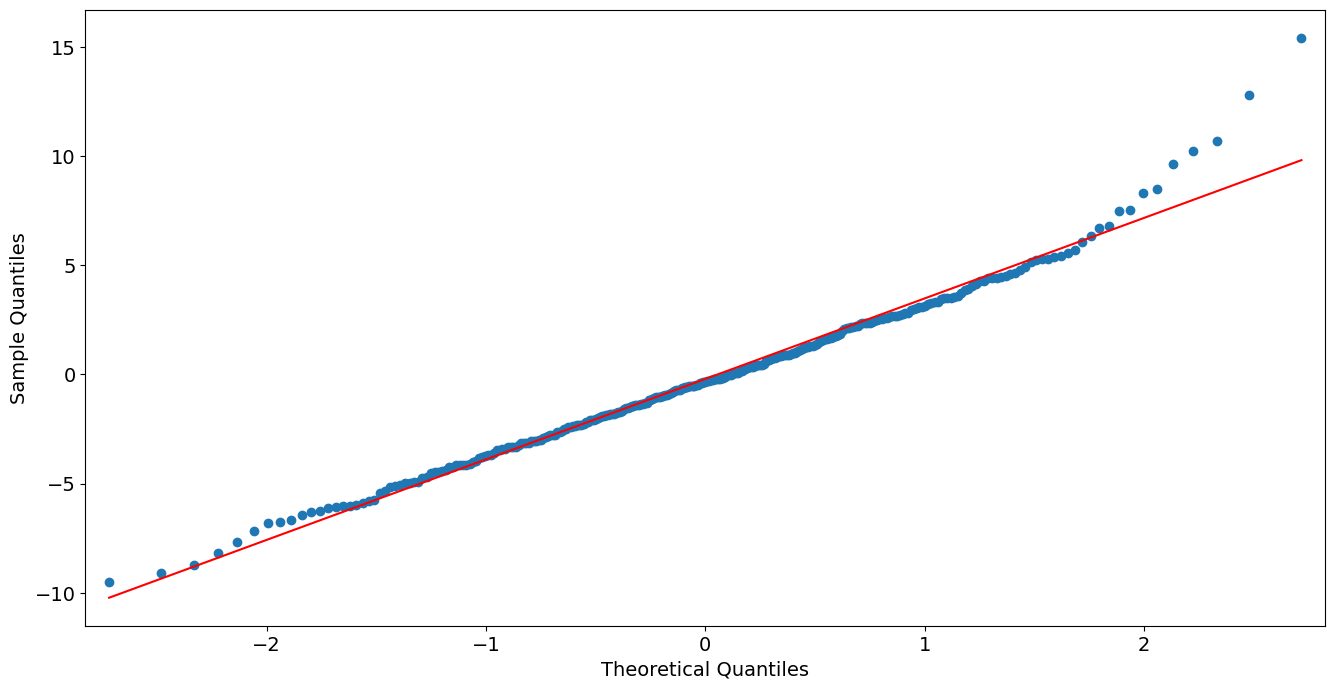

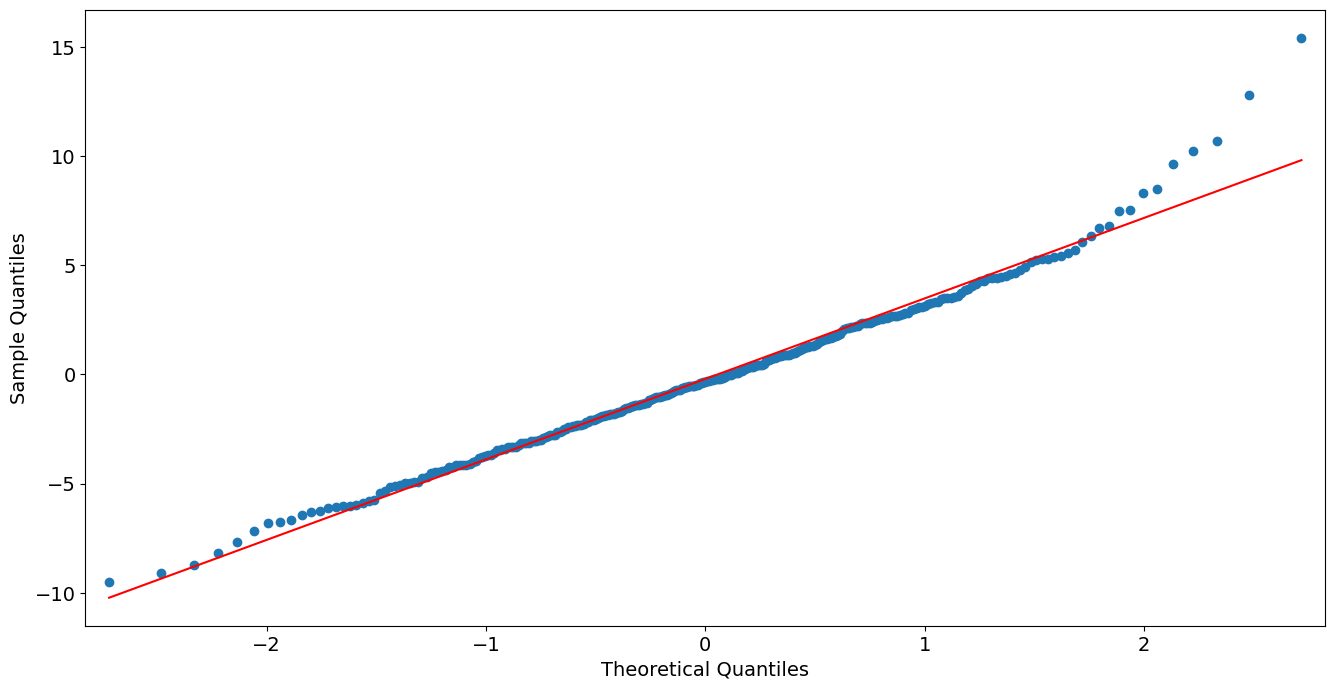

In [16]:
from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

## GLM: Gamma for proportional count response

### Load Scottish Parliament Voting data

 In the example above, we printed the ``NOTE`` attribute to learn about the
 Star98 dataset. statsmodels datasets ships with other useful information. For
 example: 

In [17]:
print(sm.datasets.scotland.DESCRLONG)


This data is based on the example in Gill and describes the proportion of
voters who voted Yes to grant the Scottish Parliament taxation powers.
The data are divided into 32 council districts.  This example's explanatory
variables include the amount of council tax collected in pounds sterling as
of April 1997 per two adults before adjustments, the female percentage of
total claims for unemployment benefits as of January, 1998, the standardized
mortality rate (UK is 100), the percentage of labor force participation,
regional GDP, the percentage of children aged 5 to 15, and an interaction term
between female unemployment and the council tax.

The original source files and variable information are included in
/scotland/src/



 Load the data and add a constant to the exogenous variables:

In [18]:
data2 = sm.datasets.scotland.load()
data2.exog = sm.add_constant(data2.exog, prepend=False)
print(data2.exog.head())
print(data2.endog.head())

   COUTAX  UNEMPF    MOR   ACT      GDP   AGE  COUTAX_FEMALEUNEMP  const
0   712.0    21.0  105.0  82.4  13566.0  12.3             14952.0    1.0
1   643.0    26.5   97.0  80.2  13566.0  15.3             17039.5    1.0
2   679.0    28.3  113.0  86.3   9611.0  13.9             19215.7    1.0
3   801.0    27.1  109.0  80.4   9483.0  13.6             21707.1    1.0
4   753.0    22.0  115.0  64.7   9265.0  14.6             16566.0    1.0
0    60.3
1    52.3
2    53.4
3    57.0
4    68.7
Name: YES, dtype: float64


### Model Fit and summary

In [19]:
glm_gamma = sm.GLM(data2.endog, data2.exog, family=sm.families.Gamma(sm.families.links.Log()))
glm_results = glm_gamma.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    YES   No. Observations:                   32
Model:                            GLM   Df Residuals:                       24
Model Family:                   Gamma   Df Model:                            7
Link Function:                    Log   Scale:                       0.0035927
Method:                          IRLS   Log-Likelihood:                -83.110
Date:                Mon, 16 Dec 2024   Deviance:                     0.087988
Time:                        09:56:10   Pearson chi2:                   0.0862
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9797
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
COUTAX                -0.0024      0

## GLM: Gaussian distribution with a noncanonical link

### Artificial data

In [20]:
nobs2 = 100
x = np.arange(nobs2)
np.random.seed(54321)
X = np.column_stack((x,x**2))
X = sm.add_constant(X, prepend=False)
lny = np.exp(-(.03*x + .0001*x**2 - 1.0)) + .001 * np.random.rand(nobs2)

### Fit and summary (artificial data)

In [21]:
gauss_log = sm.GLM(lny, X, family=sm.families.Gaussian(sm.families.links.Log()))
gauss_log_results = gauss_log.fit()
print(gauss_log_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Gaussian   Df Model:                            2
Link Function:                    Log   Scale:                      1.0531e-07
Method:                          IRLS   Log-Likelihood:                 662.92
Date:                Mon, 16 Dec 2024   Deviance:                   1.0215e-05
Time:                        09:56:10   Pearson chi2:                 1.02e-05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0300    5.6e-06  -5361.316      0.0